## Step one: load map image

{'image': 'map_name2.pgm', 'resolution': 0.05, 'origin': [-4.945325, -9.076535, 0.0], 'negate': 0, 'occupied_thresh': 0.65, 'free_thresh': 0.196}


/home/marcel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  if sys.path[0] == '':


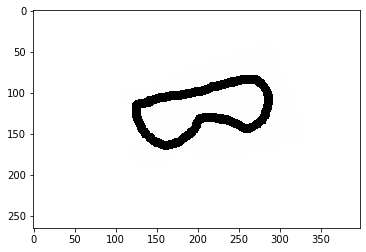

In [175]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from yaml import load, dump
import skimage
import os

MAPS_DIR = '/home/marcel/map_data/s6_6grudnia/maps/set_v1'

map_name = 'map_name'
trajectory_file = '/home/marcel/map_data/s6_6grudnia/maps/s6_trajectory_3.pgm'
with open(os.path.join(MAPS_DIR, map_name+'.yaml'), 'r') as f:
    map_meta = load(f)

print(map_meta)

map_img = mpimg.imread(os.path.join(MAPS_DIR, map_meta['image']))
trajectory_img = mpimg.imread(trajectory_file)

plt.imshow(trajectory_img, cmap='gray')
plt.show()

## Step two: identify occupied and free cells

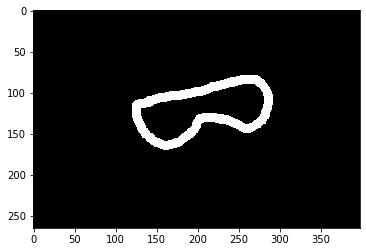

In [176]:
import numpy as np

occupied = np.zeros_like(trajectory_img)
free     = np.zeros_like(trajectory_img)
path = np.zeros_like(trajectory_img)

occupied[trajectory_img > map_meta['occupied_thresh']] = 1.0
free[trajectory_img < map_meta['free_thresh']] = 1.0

B = np.argwhere(occupied | free)
(ystart, xstart), (ystop, xstop) = B.min(0), B.max(0) + 1

free_trim = free[ystart:ystop, xstart:xstop]
black_on_white = free_trim

plt.imshow(free_trim, cmap='gray')
plt.show()

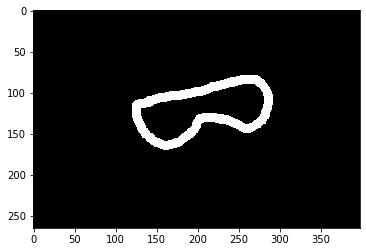

In [177]:
from skimage.morphology import binary_dilation

occupied_trim = occupied[ystart:ystop, xstart:xstop]

#for x in range(5):
#    occupied_trim = binary_dilation(occupied_trim)

#free_trim = free_trim & (~occupied_trim)

plt.imshow(free_trim, cmap='gray')
plt.show()

## Step three: identify center line

1


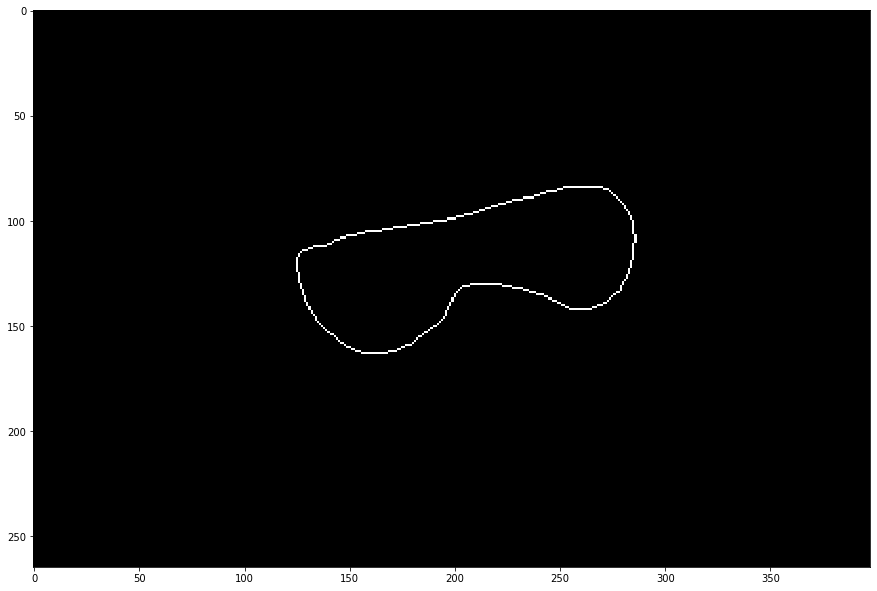

In [180]:
from skimage.morphology import binary_erosion, skeletonize, thin
from skimage.transform import resize

#img_resized = resize(map_img, (map_img.shape[0] / 2, map_img.shape[1] / 2),
#                       anti_aliasing=False)

#skeleton = skeletonize(free_trim)

#free_trim = binary_dilation(trajectory_img)

path[free_trim > map_meta['occupied_thresh']] = 1
path[free_trim <= map_meta['occupied_thresh']] = 0


oc_dilat = binary_erosion(trajectory_img)
skeleton = path
#skeleton = binary_dilation(skeleton)
#skeleton = skeletonize(skeleton)
print(np.max(skeleton))
skeleton = skeletonize(path)

plt.figure(figsize=(15, 15))
plt.imshow(skeleton, cmap='gray')
plt.show()


## Step four: extract pixels belonging to the closed circuit

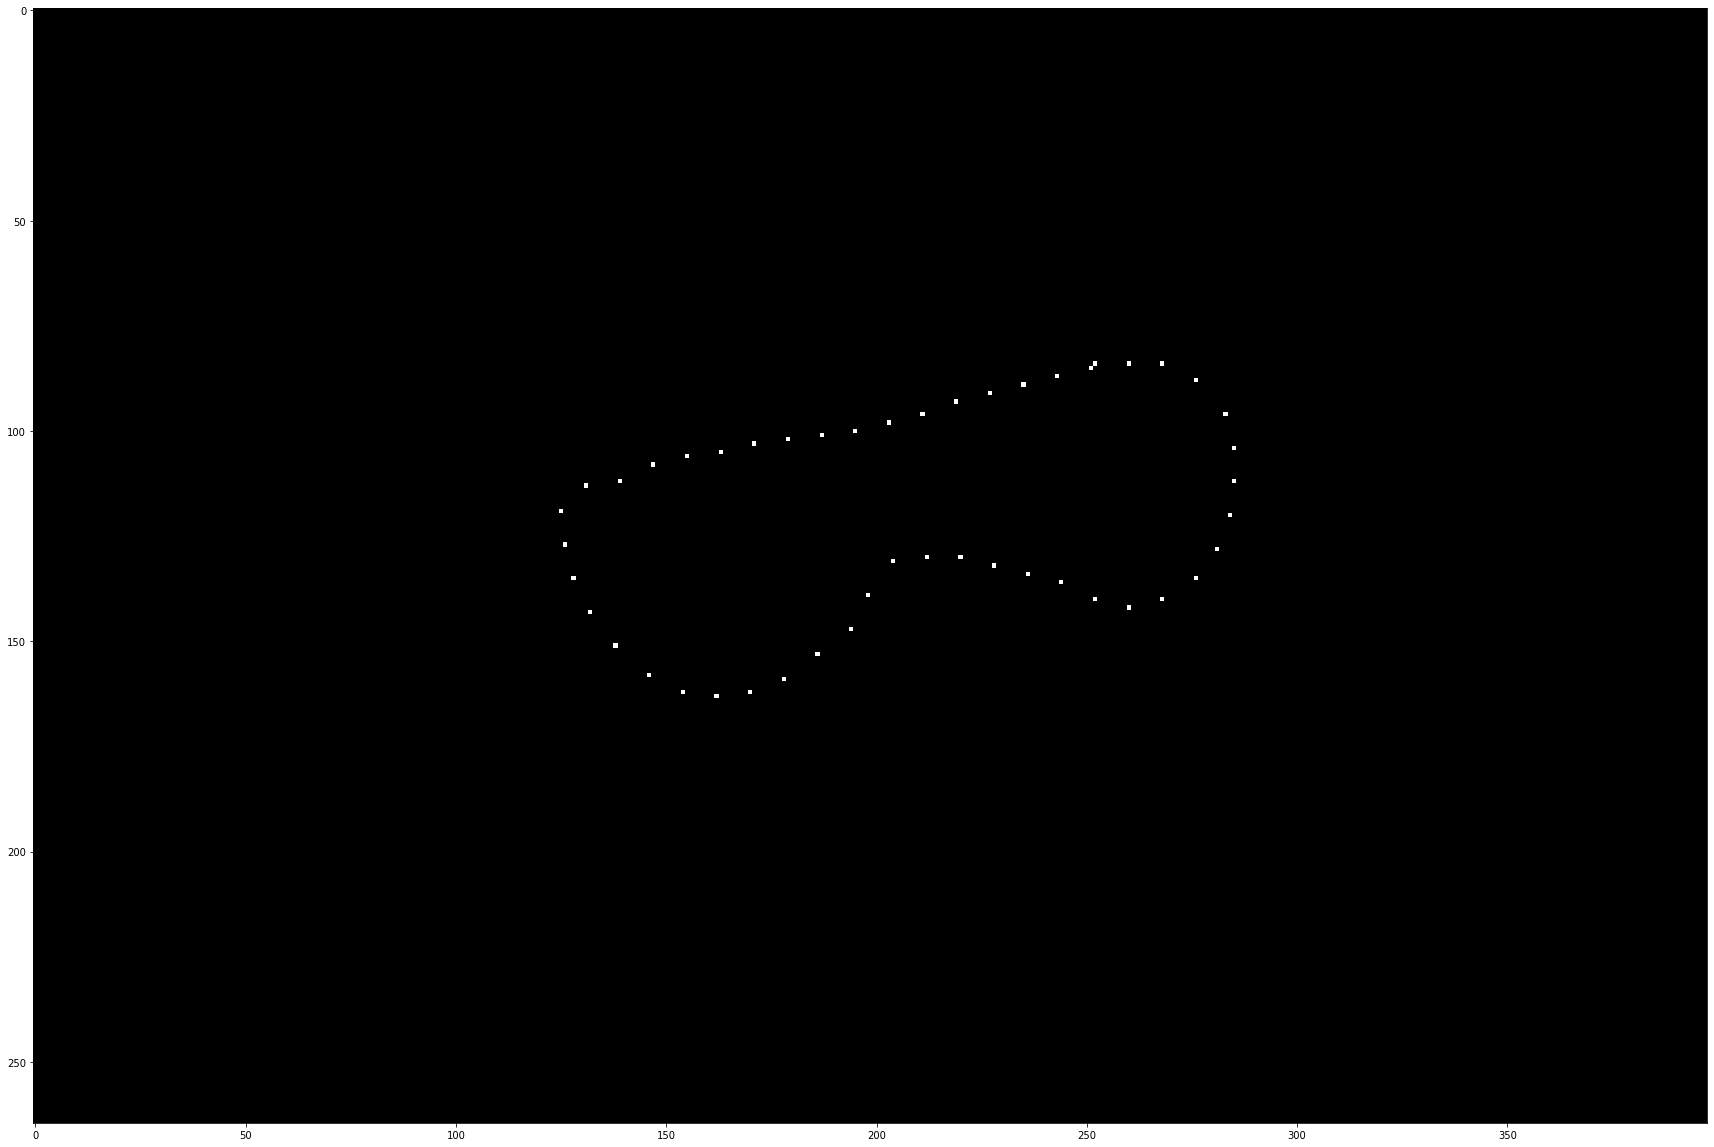

48


In [181]:
from itertools import permutations
import sys
sys.setrecursionlimit(999999999)

OFFSETS = [-1, 0, 1]
NEIGHBORHOOD = [(dy, dx) for dx in OFFSETS for dy in OFFSETS]

available = np.copy(skeleton).astype(np.bool)

def dfs(point, target, available, path, remaining_steps=15):
    x = point[0]
    y = point[1]
    
    if (remaining_steps == 0) and (point == target).all(): return True
    
    # Lower & upper bounds
    if x < 0 or x >= available.shape[1]: return False
    if y < 0 or y >= available.shape[0]: return False
    
    if not available[y, x]: return False
    
    remaining_steps = max(0, remaining_steps-1)
    
    available[y, x] = False
    path.append(point)
    
    for dx, dy in NEIGHBORHOOD:
        child_x = x + dx
        child_y = y + dy
        
        if dfs((child_x, child_y), target, available, path, remaining_steps):
            return True

    path.pop()
    return False

starting_points = np.transpose(np.nonzero(available))
for starting_point in starting_points:
    path = []
    
    if dfs(starting_point[::-1], starting_point[::-1], available, path):
        break

path = path[::-8]        
    
path_img = np.zeros_like(skeleton)
#path_img = skeleton

for point in path:
    path_img[point[1], point[0]] = 1

plt.figure(figsize=(30, 30))
plt.imshow(path_img, cmap='gray')
plt.show()

print(len(path))

## Step six: Save results to file

In [183]:
import pickle

data = {}

res = map_meta['resolution']

data['resolution'] = res
data['origin'] = [
    map_meta['origin'][0] + xstart * res,
    map_meta['origin'][1] + (map_img.shape[0] - ystop - 1) * res
]
data['pathpoints'] = [
    (data['origin'][0] + x*res, data['origin'][1] + (path_img.shape[0] - y - 1)*res)
    for x, y in path
]

with open(map_name+'.pkl', 'wb') as f:
    pickle.dump(data, f, 2)